# 進捗状況可視化ノートブック（オフライン）  

進捗状況はファイルで各ユーザのワーキングディレクトリに保存されています。  
それらの情報は、各教師のホームディレクトリ配下にあるDB（sqlite）に、担当しているコースのログ情報として自動で収集しています。  
本ノートブックでは、この情報をグラフ表示するサンプルをいくつか記載しています。  
オリジナルのデータ集計を行う場合は、本ノートブックの末尾に記載したスキーマ情報等を参照してください。

## パラメータ指定

対象のコース名等を指定します。

In [4]:
import os

ASSIGNMENT = 'assign01'

# コース名を環境変数から取得します
COURSE = os.environ['MOODLECOURSE']
DB_PATH = os.path.join(os.environ['HOME'], 'nbgrader', COURSE, 'exec_history.db')

print(ASSIGNMENT, COURSE, DB_PATH)

assign01 mcjh /home/admin/nbgrader/mcjh/exec_history.db


## サンプル

### 1. cell番号ごとの、正常終了したセルの数  

cell番号ごとの、正常終了したセルの数を集計します。  
同一ユーザが同じセルを複数回実行している場合、最新の実行結果のみを集計対象とします。

行: 正常終了数  
列: meme_id

[('49553f2e-90e5-11ef-aad1-02420a010038', 0), ('49553fa6-90e5-11ef-aad1-02420a010038', 0), ('49554028-90e5-11ef-aad1-02420a010038', 0), ('cd9eab9a-90e4-11ef-aad1-02420a010038', 1), ('cd9eac26-90e4-11ef-aad1-02420a010038', 1), ('cd9ead8e-90e4-11ef-aad1-02420a010038', 1), ('cd9eae42-90e4-11ef-aad1-02420a010038', 0), ('cd9eaf78-90e4-11ef-aad1-02420a010038', 0), ('cd9eb004-90e4-11ef-aad1-02420a010038', 0), ('db999bb0-90e4-11ef-aad1-02420a010038', 1), ('dcf728f6-90e4-11ef-aad1-02420a010038', 0)]


<BarContainer object of 11 artists>

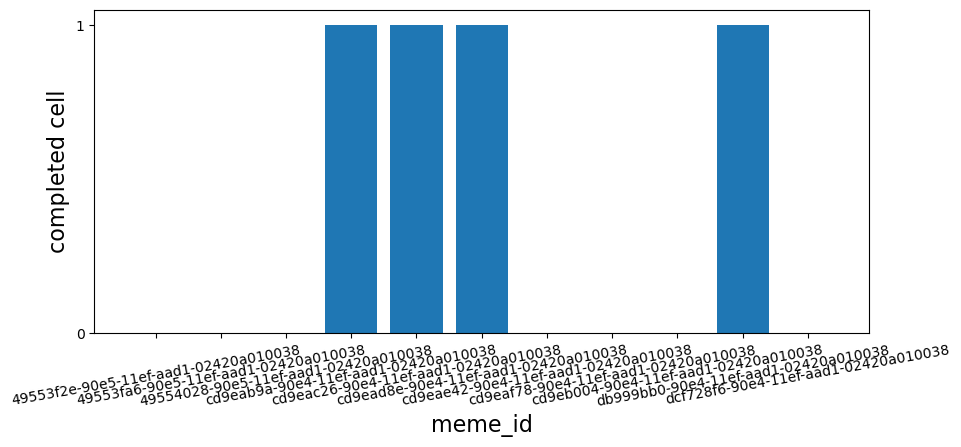

In [5]:
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

sql = """
WITH LatestLog AS (
  SELECT
    log_id.id as cell_id,
    log_id.assignment as assignment,
    student_id as student_id,
    log_execute_reply_status as log_execute_reply_status,
    CASE log_execute_reply_status
      WHEN 'ok' THEN 1
      ELSE 0
    END as ok_count,
    MAX(log_sequence) AS max_log_sequence
  FROM
    log_id left outer join log on log_id.id = log.log_id and log_id.assignment = log.assignment
  WHERE
    log_id.assignment = ?
GROUP BY
    log_id.id,
    log_id.assignment,
    student_id,
    log_execute_reply_status
)
SELECT
  cell_id,
  sum(ok_count)
FROM
  LatestLog
group by
  cell_id
;
"""

# sql = "select * from log_id where assignment = ?;"
with sqlite3.connect(f"file:{DB_PATH}?mode=ro", uri=True) as con:
    cur = con.cursor()
    cur.execute(sql, [ASSIGNMENT])
    result = cur.fetchall()
    print(result)

x = list()
y = list()
for d in result:
    x.append(d[0])
    y.append(d[1])

fig, ax = plt.subplots(figsize=[10, 4.2])
ax.tick_params('x', rotation=10)

# 自動で表示させると、Y軸が小数単位になる場合があるので、整数指定する
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('completed cell', fontsize=16)
ax.set_xlabel('meme_id', fontsize=16)
ax.bar(x, y)


### 2. 正常終了したセルの割合/時刻  

行: 正常終了率  
列: 時刻  

ログのendが対象の列の値より小さなものの中で最大のものを、その時間での集計対象とする。

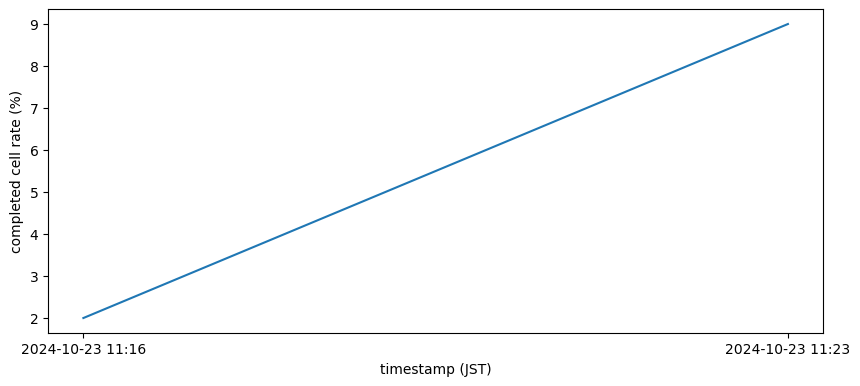

In [7]:
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import datetime

start_dt = datetime.datetime.strptime('2024/10/23 11:00:00 +0900', '%Y/%m/%d %H:%M:%S %z')
end_dt = datetime.datetime.strptime('2024/10/23 12:12:00 +0900', '%Y/%m/%d %H:%M:%S %z')

# 課題を解き終わったあとは実行しない＝ログが無い
# 経過時刻ごとに、その時刻以下の中で最新のログ（end < 各時刻）を取る
sql = """
WITH Recursive dtime_ranges AS (
    SELECT
        strftime('%Y-%m-%d %H:%M', log_end, '+9 hours') AS dtime
    FROM
        log
    WHERE
        log.assignment = ?
        AND log_end BETWEEN ? AND ?
        AND log_execute_reply_status = ?
    GROUP BY
        strftime('%Y-%m-%d %H:%M', log_end, '+9 hours')
    ORDER BY
        dtime
)
SELECT
    dtime_ranges.dtime AS dtime,
    COUNT(log.assignment)*100/total_cell.total AS rate
FROM
    log,
    dtime_ranges,
    (SELECT
        student_count.total * cell_count.total AS total,
        cell_count.assignment AS assignment
     FROM
        (SELECT COUNT(*) as total
         FROM student) student_count,
        (SELECT assignment, COUNT(*) as total
         FROM log_id
         GROUP BY assignment) cell_count
    ) total_cell
WHERE
    log.assignment = total_cell.assignment
    AND log.assignment = ?
    AND strftime('%Y-%m-%d %H:%M', log.log_end, '+9 hours') <= dtime_ranges.dtime
GROUP BY
    dtime_ranges.dtime
ORDER BY
    dtime_ranges.dtime;

"""

with sqlite3.connect(f"file:{DB_PATH}?mode=ro", uri=True) as con:
    # 列名で結果にアクセスできるようにする
    con.row_factory = sqlite3.Row
    cur = con.cursor()
    cur.execute(sql, (ASSIGNMENT, start_dt, end_dt, 'ok', ASSIGNMENT))
    result = cur.fetchall()

x = list()
y = list()
for d in result:
    x.append(d['dtime'])
    y.append(d['rate'])

fig, ax = plt.subplots(figsize=[10, 4.2])
ax.set_ylabel('completed cell rate (%)')
ax.set_xlabel('timestamp (JST)')
ax.plot(x, y)


## 3. セルごとの正常終了人数

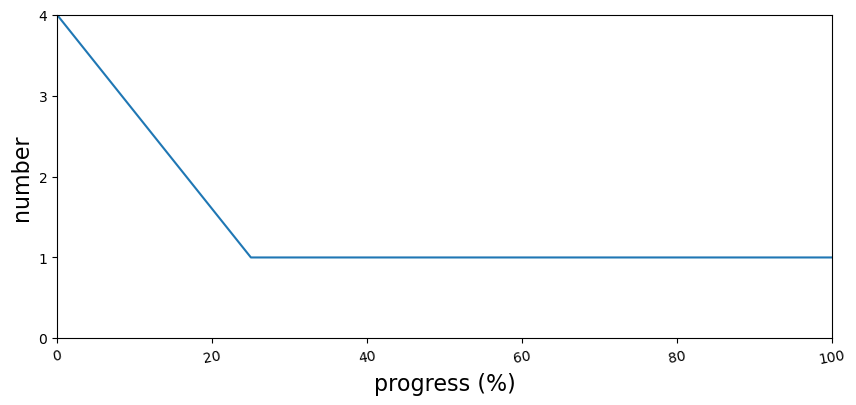

In [9]:
import datetime

import sqlite3
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

dt_to = datetime.datetime.strptime('2024-10-23 16:00:44 +0900', '%Y-%m-%d %H:%M:%S %z')

sql = """
WITH LatestLog AS (
  SELECT
    log_id.id as cell_id,
    log_id.assignment as assignment,
    student_id as student_id,
    log_execute_reply_status as log_execute_reply_status,
    CASE log_execute_reply_status
      WHEN 'ok' THEN 1
      ELSE 0
    END as ok_count,
    MAX(log_sequence) AS max_log_sequence
  FROM
    log_id left outer join log on log_id.id = log.log_id and log_id.assignment = log.assignment
  WHERE
    log_id.assignment = ?
    AND log_end < ?
GROUP BY
    log_id.id,
    log_id.assignment,
    student_id,
    log_execute_reply_status
)
SELECT
  ROW_NUMBER() OVER(ORDER BY cell_id ASC) num,
  cell_id,
  sum(ok_count) AS ok_num,
  student.num AS student_num
FROM
  LatestLog,
  (SELECT COUNT(*) num
   FROM student) AS student
group by
  cell_id
order by
  cell_id
;
"""

with sqlite3.connect(f"file:{DB_PATH}?mode=ro", uri=True) as con:
    # 列名で結果にアクセスできるようにする
    con.row_factory = sqlite3.Row
    cur = con.cursor()
    cur.execute(sql, [ASSIGNMENT, dt_to])
    result = cur.fetchall()

# 0個目のセル（実際は存在しない）の位置は全員該当（クリア済）として初期化
x = [0]
y = [result[0]['student_num']]
for d in result:
    x.append(d['num']*100/len(result))
    y.append(d['ok_num'])

fig, ax = plt.subplots(figsize=[10, 4.2])
ax.tick_params('x', rotation=10)

# 自動で表示させると、Y軸が小数単位になる場合があるので、整数指定する
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim(0, 100)
ax.set_ylim(0, result[0][3])
ax.set_ylabel('number', fontsize=16)
ax.set_xlabel('progress (%)', fontsize=16)
ax.plot(x, y)


### 4. 試行回数/試行時間  

行: 試行回数
列: 時間

[0] [1]


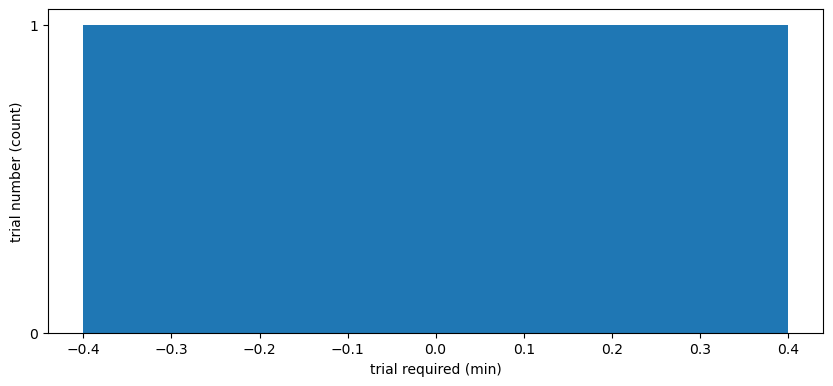

In [15]:
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import datetime

dt_from = datetime.datetime.strptime('2024-10-23 10:40:44 +0900', '%Y-%m-%d %H:%M:%S %z')
dt_to = datetime.datetime.strptime('2024-10-23 13:00:44 +0900', '%Y-%m-%d %H:%M:%S %z')
cell_id = 'cd9eab9a-90e4-11ef-aad1-02420a010038'
threshold_execution_seconds = 60 * 30 #課題に取り組んでいない（離席中）とみなす時間

sql = """
SELECT
  student_id,
  SUM(working_time) as total_working_time,
  COUNT(*) as total_working_quant
  FROM (SELECT
            student_id,
            ifnull(unixepoch(log_end) - unixepoch(LAG(log_end, 1) OVER (PARTITION BY student_id ORDER BY datetime(log_end))), 0) AS working_time,
            log_end
          FROM log
          WHERE log.assignment = ?
          AND   log_id = ?
          AND   log_end between ? AND ?
          AND   log_execute_reply_status = ?
          ) duration
  WHERE working_time < ?
  GROUP BY
    student_id
"""

with sqlite3.connect(f"file:{DB_PATH}?mode=ro", uri=True) as con:
    # 列名で結果にアクセスできるようにする
    con.row_factory = sqlite3.Row
    cur = con.cursor()
    cur.execute(sql, [ASSIGNMENT, cell_id,dt_from,dt_to, 'ok', threshold_execution_seconds])
    result = cur.fetchall()

x = list()
y = list()
for d in result:
    x.append(d['total_working_time']//60)
    y.append(int(d['total_working_quant']))

fig, ax = plt.subplots(figsize=[10, 4.2])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('trial required (min)')
ax.set_ylabel('trial number (count)')
ax.bar(x, y)


## 補足情報

以下に、自身でオリジナルのデータを取得する際の参考資料を記載しています。

### テーブルスキーマ

ログ情報を貯めているDBのスキーマです。

#### log

| No. | 論理名                         | 物理名                         | データ型                       | Not Null | デフォルト           | 備考                           |
|----:|:-------------------------------|:-------------------------------|:-------------------------------|:---------|:---------------------|:-------------------------------|
|   1 |                                | id                             | INTEGER                        | Yes (PK) |                      |                                |
|   2 |                                | assignment                     | VARCHAR()                      | Yes      |                      |                                |
|   3 |                                | student_id                     | VARCHAR()                      | Yes      |                      |                                |
|   4 |                                | log_id                         | VARCHAR()                      | Yes      |                      |                                |
|   5 |                                | log_sequence                   | INTEGER                        | Yes      |                      |                                |
|   7 |                                | notebook_name                  | VARCHAR()                      |          |                      |                                |
|   6 |                                | log_whole                      | JSON                           |          |                      |                                |
|   7 |                                | log_code                       | VARCHAR()                      |          |                      |                                |
|   8 |                                | log_path                       | VARCHAR()                      |          |                      |                                |
|   9 |                                | log_start                      | TIMESTAMP                      |          |                      |                                |
|  10 |                                | log_end                        | TIMESTAMP                      |          |                      |                                |
|  11 |                                | log_size                       | INTEGER                        |          |                      |                                |
|  12 |                                | log_server_signature           | VARCHAR()                      |          |                      |                                |
|  13 |                                | log_uid                        | INTEGER                        |          |                      |                                |
|  14 |                                | log_gid                        | INTEGER                        |          |                      |                                |
|  15 |                                | log_notebook_path              | VARCHAR()                      |          |                      |                                |
|  16 |                                | log_lc_notebook_meme           | VARCHAR()                      |          |                      |                                |
|  17 |                                | log_execute_reply_status       | VARCHAR()                      |          |                      |                                |

※ 「assignment,student_id,log_id,log_sequence」 の組み合わせに対して、ユニーク制約を設定

#### log_id
| No. | 論理名                         | 物理名                         | データ型                       | Not Null | デフォルト           | 備考                           |
|----:|:-------------------------------|:-------------------------------|:-------------------------------|:---------|:---------------------|:-------------------------------|
|   1 |                                | id                             | VARCHAR()                      | Yes      |                      |                                |
|   2 |                                | assignment                     | VARCHAR()                      | Yes      |                      |                                |
|   2 |                                | section                        | VARCHAR()                      |          |                      |                                |
|   2 |                                | notebook_name                  | VARCHAR()                      |          |                      |                                |

※ 「id, assignment」 の組み合わせに対して、ユニーク制約を設定


#### student
| No. | 論理名                         | 物理名                         | データ型                       | Not Null | デフォルト           | 備考                           |
|----:|:-------------------------------|:-------------------------------|:-------------------------------|:---------|:---------------------|:-------------------------------|
|   1 |                                | id                             | VARCHAR()                      | Yes (PK) |                      |                                |